In [1]:
# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    USING_COLAB = True
except:
    USING_COLAB = False

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from datasets import load_dataset
import glob
import json
import concurrent.futures
import os
import time

In [3]:
# !pip install nlpaug

In [4]:
import torch
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import nlpaug.augmenter.word as naw
import math

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
if USING_COLAB:
    _METADATA_PATH = "/content/drive/My Drive/GTSI/Codigos_investigadores/supervised_new_data/dataset/hupd_metadata_2022-02-22.feather"
    path_dataset = "/content/drive/My Drive/GTSI/Codigos_investigadores/supervised_new_data/dataset"
    path_dataset_USPTO = "/content/drive/My Drive/GTSI/Codigos_investigadores/nesupervised_new_dataw_data/dataset/USPTO"
    path_output = "/content/drive/My Drive/GTSI/Codigos_investigadores/supervised_new_data/dataset/target"
else:
    _METADATA_PATH = "./dataset/hupd_metadata_2022-02-22.feather"
    path_dataset = "./dataset"
    path_dataset_USPTO = "./dataset/USPTO"
    path_output = "./dataset/target"

##### Por año

In [ ]:
# year = "2018"
# list_patents = glob.glob(path_dataset + "/patentes_" + year + "_paralelo_*.csv")
# list_patents.sort() # Sort the list of patents ascendingly

In [8]:
# for file in list_patents:
#     print(f"Processing file: {file}")
#     df = pd.read_csv(file)
#     df = df[['aplication_number', 'publication_number', 'title', 'abstract', 'decision']]
#     print(f"Number of rows in {file}: {df.shape[0]}")
#     print(df["decision"].value_counts())
#     print("-"*10)

#     df_target = df[((df["decision"] == "REJECTED") | (df["decision"] == "ACCEPTED"))]
#     print(f"Number of target rows: {df_target.shape[0]}")

#     df_target_oring = pd.read_csv(path_dataset + "/patentes_target_" + year + ".csv")
#     print(f"Number of original target rows: {df_target_oring.shape[0]}")

#     print("-"*10)
#     df_new = pd.concat([df_target_oring, df_target], axis=0).drop_duplicates()
#     print(f"Number of new target rows: {df_new.shape[0]}")
#     print("-"*10)

#     df_new.to_csv(path_dataset + "/patentes_target_" + year + ".csv", index=False)
#     print(f"Saved new target rows to {path_dataset}/patentes_target_" + year + ".csv")
#     print("="*50)


##### Target

In [9]:
# list_patents_target = glob.glob(path_dataset + "/patentes_target_*.csv")
# df_results = pd.DataFrame()

In [10]:
# for file in list_patents_target:
#     print(f"Processing file: {file}")
#     df = pd.read_csv(file)
#     print(f"Number of rows in {file}: {df.shape[0]}")
#     if df_results.empty:
#         df_results = df.copy()
#     else:
#         df_results = pd.concat([df_results, df], axis=0, ignore_index=True)
#     print(f"Number of rows in results DataFrame: {df_results.shape[0]}")
#     print("-" * 10)

In [11]:
# df_results.to_csv(path_dataset + "/patentes_target.csv", index=False)

##### EDA (Análisis Exploratorio de Datos)

In [12]:
df = pd.read_csv(path_dataset + "/patentes_target.csv")

In [13]:
df.head()

,aplication_number,publication_number,title,abstract,decision
0,14176610,US20140159107A1-20140612,SEMICONDUCTOR DEVICE,Some aspects of the invention include a trench...,ACCEPTED
1,14176611,US20140225674A1-20140814,BI-DIRECTIONAL POWER SUPPLY SIGNAL BASED LINEA...,"Circuitry, which includes a linear amplifier, ...",ACCEPTED
2,14176612,US20140212394A1-20140731,NOVEL VIP3 TOXINS AND METHODS OF USE,Nucleic acid molecules encoding novel Vip3 tox...,ACCEPTED
3,14176614,US20140227940A1-20140814,SOLAR-POWERED ROTATING ORNAMENTAL DEVICE,A device providing a spinning ornamental desig...,REJECTED
4,14176615,US20140153098A1-20140605,OPTICAL FILTER AND OPTICAL MODULE HAVING OPTIC...,"An optical filter includes a first substrate, ...",ACCEPTED


In [14]:
df["decision"].value_counts()

decision
ACCEPTED    579769
REJECTED    178623
Name: count, dtype: int64

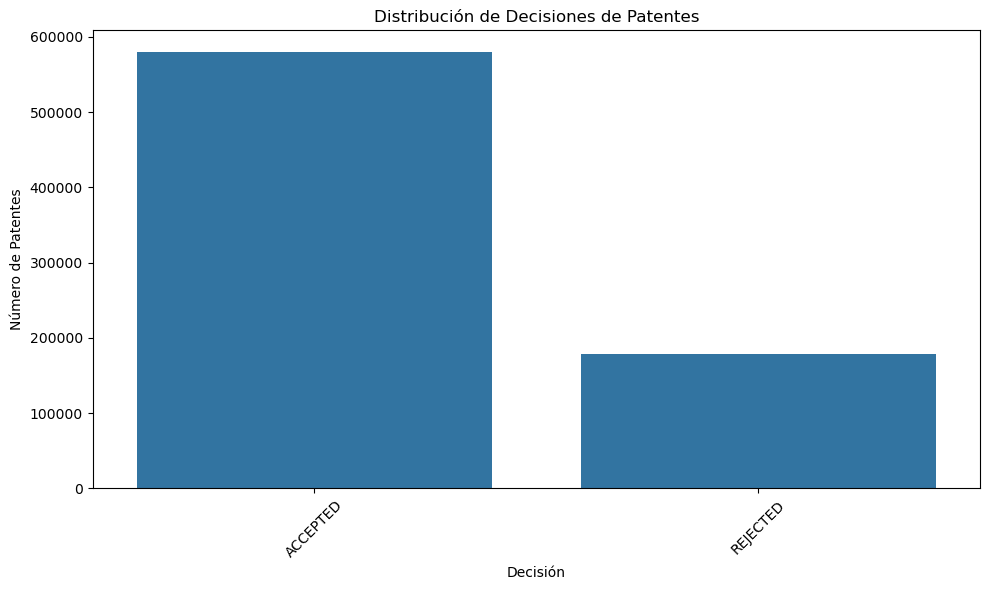

In [15]:
# diagrama de barras de la columna "decision"
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='decision', order=df['decision'].value_counts().index)
plt.title('Distribución de Decisiones de Patentes')
plt.xlabel('Decisión')
plt.ylabel('Número de Patentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Balanceo de datos

Nlpaug generates new text data, while DataFrame.sample() returns a subset of the original DataFrame.

###### Opcion 1 de balanceo


In [72]:
# # equilibrar las clases
# df_rejected = df[df["decision"] == "REJECTED"]
# df_accepted = df[df["decision"] == "ACCEPTED"]
# df_rejected = df_rejected.sample(n=len(df_accepted), random_state=42, replace=True)
# df_balanced = pd.concat([df_rejected, df_accepted], axis=0, ignore_index=True)
# df_balanced["decision"].value_counts()

In [73]:
# df_balanced["title"].value_counts()

In [74]:
# df[df["title"] == "SEMICONDUCTOR DEVICE"].shape, df_balanced[df_balanced["title"] == "SEMICONDUCTOR DEVICE"].shape

In [75]:
# # diagrama de barras de la columna "decision"
# plt.figure(figsize=(10, 6))
# sns.countplot(data=df_balanced, x='decision', order=df_balanced['decision'].value_counts().index)
# plt.title('Distribución de Decisiones de Patentes')
# plt.xlabel('Decisión')
# plt.ylabel('Número de Patentes')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

###### opcion 2 de balanceo

In [ ]:
def balance_with_multi_gpu(df, text_col='abstract', label_col='decision', gpu_ids=[0, 1]):
    """Balancea dataset usando múltiples GPUs para patentes"""
    # Verificar GPUs disponibles
    available_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0
    print(f"GPUs disponibles: {available_gpus}")

    if available_gpus == 0:
        print("⚠️ No hay GPUs disponibles, usando CPU")
        gpu_ids = ['cpu']
    elif available_gpus < len(gpu_ids):
        print(f"⚠️ Solo {available_gpus} GPUs disponibles, usando las primeras {available_gpus}")
        gpu_ids = gpu_ids[:available_gpus]


    augmenters = {}
    for gpu_id in gpu_ids:
        device = f'cuda:{gpu_id}' if gpu_id != 'cpu' else 'cpu'
        augmenters[gpu_id] = naw.ContextualWordEmbsAug(
            model_path='bert-base-multilingual-uncased',
            aug_p=0.1,
            device=device
        )
        print(f"✅ Augmenter creado en {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}")

    # Análisis de clases
    class_counts = df[label_col].value_counts()
    target_count = class_counts.max()

    print(f"\nDistribución actual:")
    for class_label, count in class_counts.items():
        print(f"  {class_label}: {count:,}")
    print(f"\nObjetivo: {target_count:,} muestras por clase")

    def process_class_on_gpu(args):
        """Procesa una clase en una GPU específica"""
        class_label, needed_samples, class_texts, gpu_id = args

        augmenter = augmenters[gpu_id]
        augmented_data = []

        print(f"🚀 {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: Procesando clase {class_label} ({needed_samples:,} muestras)")

        batch_size = 16
        for i in range(0, needed_samples, batch_size):
            batch_end = min(i + batch_size, needed_samples)
            batch_texts = [class_texts[j % len(class_texts)] for j in range(i, batch_end)]

            try:
                augmented_batch = augmenter.augment(batch_texts, 
                                                    n=math.ceil((batch_end - i) / len(class_texts)),
                                                    num_thread=1 if gpu_id == 'cpu' else 4)

                for j, aug_text in enumerate(augmented_batch):
                    # Mantener las columnas originales del dataframe
                    original_row = df[df[label_col] == class_label].iloc[j % len(class_texts)]

                    augmented_data.append({
                        'aplication_number': f"AUG_{original_row['aplication_number']}_{i+j}",
                        'publication_number': f"AUG_{original_row['publication_number']}_{i+j}",
                        'title': original_row['title'],  # Mantener título original
                        text_col: aug_text,  # Abstract aumentado
                        label_col: class_label,
                        'gpu_used': gpu_id
                    })

            except Exception as e:
                print(f"Error en {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: {e}")
                # Fallback: duplicar datos originales
                for j, text in enumerate(batch_texts):
                    original_row = df[df[label_col] == class_label].iloc[j % len(class_texts)]

                    augmented_data.append({
                        'aplication_number': f"DUP_{original_row['aplication_number']}_{i+j}",
                        'publication_number': f"DUP_{original_row['publication_number']}_{i+j}",
                        'title': original_row['title'],
                        text_col: text,
                        label_col: class_label,
                        'gpu_used': gpu_id
                    })

        print(f"✅ {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: Completada clase {class_label}")
        return augmented_data

    # Preparar trabajos para cada GPU
    jobs = []
    gpu_idx = 0

    for class_label, current_count in class_counts.items():
        needed = target_count - current_count
        if needed <= 0:
            print(f"Clase {class_label} ya tiene suficientes muestras ({current_count:,})")
            continue

        class_texts = df[df[label_col] == class_label][text_col].tolist()
        gpu_id = gpu_ids[gpu_idx % len(gpu_ids)]

        jobs.append((class_label, needed, class_texts, gpu_id))
        gpu_idx += 1

        print(f"📋 Clase {class_label}: necesita {needed:,} muestras adicionales -> {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}")

    if not jobs:
        print("✅ El dataset ya está balanceado")
        return df

    # Ejecutar en paralelo
    all_augmented_data = []
    with ThreadPoolExecutor(max_workers=len(gpu_ids)) as executor:
        results = executor.map(process_class_on_gpu, jobs)

        for result in results:
            all_augmented_data.extend(result)

    # Combinar resultados
    if all_augmented_data:
        augmented_df = pd.DataFrame(all_augmented_data)
        balanced_df = pd.concat([df, augmented_df], ignore_index=True)
    else:
        balanced_df = df.copy()

    print(f"\n🎉 Completado!")
    print(f"Total original: {len(df):,}")
    print(f"Total final: {len(balanced_df):,}")
    print(f"Muestras añadidas: {len(all_augmented_data):,}")

    # Mostrar distribución final
    final_counts = balanced_df[label_col].value_counts()
    print(f"\nDistribución final:")
    for class_label, count in final_counts.items():
        print(f"  {class_label}: {count:,}")

    # Mostrar uso por GPU
    if len(all_augmented_data) > 0:
        augmented_df_temp = pd.DataFrame(all_augmented_data)
        gpu_usage = augmented_df_temp['gpu_used'].value_counts()
        print("\nUso por GPU:")
        for gpu_id, count in gpu_usage.items():
            print(f"  {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: {count:,} muestras")

    return balanced_df

In [77]:
# # Usar con 1 GPU
# balanced_df = balance_with_multi_gpu(df, gpu_ids=[0])

# # Usar con 2 GPUs
# # balanced_df = balance_with_multi_gpu(df, gpu_ids=[0, 1])

In [78]:
# balanced_df.to_csv(path_dataset + "/patentes_target_balanced.csv", index=False)

In [79]:

# df_example = pd.DataFrame(sample_data)
# print("Datos de ejemplo:")
# print(df_example.head())
# print(f"\nDistribución original:")
# print(df_example['decision'].value_counts())

# # Simular el balanceo (sin GPUs reales para el ejemplo)
# print("\n" + "="*50)
# print("SIMULACIÓN DE BALANCEO")
# print("="*50)

# # balanced_df = balance_with_multi_gpu(df_example, gpu_ids=[0])

In [ ]:
def balance_with_multi_gpu_parallel(df, text_col='abstract', label_col='decision', gpu_ids=[0, 1]):
    """Balancea dataset usando múltiples GPUs con paralelización intra-clase"""
    # Verificar GPUs disponibles
    available_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0
    print(f"GPUs disponibles: {available_gpus}")

    if available_gpus == 0:
        print("⚠️ No hay GPUs disponibles, usando CPU")
        gpu_ids = ['cpu']
    elif available_gpus < len(gpu_ids):
        print(f"⚠️ Solo {available_gpus} GPUs disponibles, usando las primeras {available_gpus}")
        gpu_ids = gpu_ids[:available_gpus]

    # Crear augmenters para cada GPU
    augmenters = {}
    for gpu_id in gpu_ids:
        device = f'cuda:{gpu_id}' if gpu_id != 'cpu' else 'cpu'
        augmenters[gpu_id] = naw.ContextualWordEmbsAug(
            model_path='bert-base-multilingual-uncased',
            aug_p=0.1,
            device=device
        )
        print(f"✅ Augmenter creado en {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}")

    # Análisis de clases
    class_counts = df[label_col].value_counts()
    target_count = class_counts.max()

    print(f"\nDistribución actual:")
    for class_label, count in class_counts.items():
        print(f"  {class_label}: {count:,}")
    print(f"\nObjetivo: {target_count:,} muestras por clase")

    def process_batch_on_gpu(args):
        """Procesa un lote de una clase en una GPU específica"""
        class_label, batch_start, batch_size, class_texts, gpu_id, total_needed = args

        augmenter = augmenters[gpu_id]
        augmented_data = []

        batch_end = min(batch_start + batch_size, total_needed)
        actual_batch_size = batch_end - batch_start
        print("actual_batch_size", actual_batch_size, "batch_end", batch_end, "batch_start", batch_start)

        print(f"🚀 {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: Procesando clase {class_label} "
              f"[{batch_start:,}-{batch_end:,}] ({actual_batch_size:,} muestras)")

            
        # Procesar en mini-batches
        mini_batch_size = 16
        for i in range(0, actual_batch_size, mini_batch_size):
            mini_end = min(i + mini_batch_size, actual_batch_size)
            print("desde", i, "hasta", mini_end, "mini_batch_size", mini_batch_size, "actual_batch_size", actual_batch_size)
            mini_texts = [class_texts[j % len(class_texts)] for j in range(i, mini_end)]
            print(f"  Procesando mini-batch {i // mini_batch_size + 1}, i {i}, mini_end {mini_end}, mini_texts {len(mini_texts)}")

            try:
                augmented_batch = augmenter.augment(mini_texts, 
                                                    n=math.ceil((batch_end - i) / len(class_texts)),
                                                    num_thread=1 if gpu_id == 'cpu' else 4)

                for j, aug_text in enumerate(augmented_batch):
                    # Mantener las columnas originales del dataframe
                    original_idx = (i + j) % len(class_texts)
                    original_row = df[df[label_col] == class_label].iloc[original_idx]

                    global_idx = batch_start + i + j
                    augmented_data.append({
                        'aplication_number': f"AUG_GPU{gpu_id}_{original_row['aplication_number']}_{global_idx}",
                        'publication_number': f"AUG_GPU{gpu_id}_{original_row['publication_number']}_{global_idx}",
                        'title': original_row['title'],
                        text_col: aug_text,
                        label_col: class_label,
                        'gpu_used': gpu_id,
                        'batch_id': f"{class_label}_GPU{gpu_id}_{batch_start}-{batch_end}"
                    })

            except Exception as e:
                print(f"Error en {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: {e}")
                # Fallback
                for j, text in enumerate(mini_texts):
                    original_idx = (i + j) % len(class_texts)
                    original_row = df[df[label_col] == class_label].iloc[original_idx]

                    global_idx = batch_start + i + j
                    augmented_data.append({
                        'aplication_number': f"DUP_GPU{gpu_id}_{original_row['aplication_number']}_{global_idx}",
                        'publication_number': f"DUP_GPU{gpu_id}_{original_row['publication_number']}_{global_idx}",
                        'title': original_row['title'],
                        text_col: text,
                        label_col: class_label,
                        'gpu_used': gpu_id,
                        'batch_id': f"{class_label}_GPU{gpu_id}_{batch_start}-{batch_end}"
                    })
            finally:
                print(f"✅ {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: Completado lote {class_label} batch {i // batch_size + 1} ({len(augmented_data):,} muestras), i {i})")

        print(f"✅ {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: Completado lote {class_label} "
              f"[{batch_start:,}-{batch_end:,}] - {len(augmented_data)} muestras generadas")
        return augmented_data

    # Preparar trabajos dividiendo cada clase entre GPUs
    all_jobs = []

    for class_label, current_count in class_counts.items():
        needed = target_count - current_count
        
        if needed <= 0:
            print(f"Clase {class_label} ya tiene suficientes muestras ({current_count:,})")
            continue

        print("needed", needed, "needed menos", 5000)
        needed = 5000
        
        class_texts = df[df[label_col] == class_label][text_col].tolist()
        class_texts.reverse()

        num_batches = 8  # O el número de hilos que quieras
        batch_size = math.ceil(needed / num_batches)
        for i in range(num_batches):
            batch_start = i * batch_size
            if batch_start >= needed:
                break
            this_batch_size = min(batch_size, needed - batch_start)
            all_jobs.append((class_label, batch_start, this_batch_size, class_texts, gpu_ids[0], needed))


        # # Dividir el trabajo de esta clase entre todas las GPUs disponibles
        # samples_per_gpu = math.ceil(needed / len(gpu_ids))

        # print(f"\n📋 Clase {class_label}: necesita {needed:,} muestras adicionales")
        # print(f"   Dividiendo en ~{samples_per_gpu:,} muestras por GPU")

        # for i, gpu_id in enumerate(gpu_ids):
        #     batch_start = i * samples_per_gpu
        #     if batch_start >= needed:
        #         break  # Ya no hay más trabajo para esta GPU

        #     batch_size = min(samples_per_gpu, needed - batch_start)

        #     all_jobs.append((class_label, batch_start, batch_size, class_texts, gpu_id, needed))

        #     print(f"   -> {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: "
        #           f"muestras {batch_start:,}-{batch_start + batch_size:,} ({batch_size:,} muestras)")

    if not all_jobs:
        print("✅ El dataset ya está balanceado")
        return df

    print(f"\n🔥 Total de trabajos paralelos: {len(all_jobs)}")

    # Ejecutar todos los trabajos en paralelo
    all_augmented_data = []
    max_workers = min(len(all_jobs), len(gpu_ids) * 2)  # Limitar workers
    # max_workers = len(all_jobs)
    print("max_workers", max_workers, len(all_jobs), len(gpu_ids))

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = executor.map(process_batch_on_gpu, all_jobs)

        for result in results:
            all_augmented_data.extend(result)

    # Combinar resultados
    if all_augmented_data:
        augmented_df = pd.DataFrame(all_augmented_data)
        balanced_df = pd.concat([df, augmented_df], ignore_index=True)
    else:
        balanced_df = df.copy()

    print(f"\n🎉 Completado!")
    print(f"Total original: {len(df):,}")
    print(f"Total final: {len(balanced_df):,}")
    print(f"Muestras añadidas: {len(all_augmented_data):,}")

    # Mostrar distribución final
    final_counts = balanced_df[label_col].value_counts()
    print(f"\nDistribución final:")
    for class_label, count in final_counts.items():
        print(f"  {class_label}: {count:,}")

    # Mostrar uso detallado por GPU
    if len(all_augmented_data) > 0:
        augmented_df_temp = pd.DataFrame(all_augmented_data)

        print("\n📊 Uso detallado por GPU:")
        gpu_usage = augmented_df_temp.groupby(['gpu_used', label_col]).size().reset_index(name='count')

        for gpu_id in gpu_ids:
            gpu_data = gpu_usage[gpu_usage['gpu_used'] == gpu_id]
            total_gpu = gpu_data['count'].sum()
            print(f"\n  {'GPU' if gpu_id != 'cpu' else 'CPU'} {gpu_id}: {total_gpu:,} muestras totales")

            for _, row in gpu_data.iterrows():
                print(f"    - {row[label_col]}: {row['count']:,}")

    return balanced_df

In [81]:
balanced_df = balance_with_multi_gpu_parallel(df, gpu_ids=[0])
# balanced_df = balance_with_multi_gpu_parallel(df, gpu_ids=[0, 1])

# 100286 = 7h
# 5000 = 424m local
# 1000 = 90m local
# 1000 = 93min local

GPUs disponibles: 0
⚠️ No hay GPUs disponibles, usando CPU
✅ Augmenter creado en CPU cpu

Distribución actual:
  ACCEPTED: 579,769
  REJECTED: 178,623

Objetivo: 579,769 muestras por clase
Clase ACCEPTED ya tiene suficientes muestras (579,769)
needed 401146 needed menos 1000

🔥 Total de trabajos paralelos: 8
max_workers 2 8 1
actual_batch_size 125 batch_end 125 batch_start 0
🚀 CPU cpu: Procesando clase REJECTED [0-125] (125 muestras)
desde 0 hasta 16 mini_batch_size 16 actual_batch_size 125
  Procesando mini-batch 1, i 0, mini_end 16, mini_texts 16
actual_batch_size 125 batch_end 250 batch_start 125
🚀 CPU cpu: Procesando clase REJECTED [125-250] (125 muestras)
desde 0 hasta 16 mini_batch_size 16 actual_batch_size 125
  Procesando mini-batch 1, i 0, mini_end 16, mini_texts 16
✅ CPU cpu: Completado lote REJECTED batch 1 (16 muestras), i 0)
desde 16 hasta 32 mini_batch_size 16 actual_batch_size 125
  Procesando mini-batch 2, i 16, mini_end 32, mini_texts 16
✅ CPU cpu: Completado lote REJE

In [ ]:
balanced_df.to_csv(path_output + "/patentes_target_balanced_15.csv", index=False)

In [ ]:
print("cantidad de", ((((((579769 - 178623)//4))))), "en", ((((((579769 - 178623)//4)//32)*10)/60)/60), "horas")

cantidad de 100286 en 8.702777777777778 horas


In [ ]:
print("cantidad de", ((((((579769 - 178623)//64))))), "en", ((((((579769 - 178623)//4)//32)*10)/60)/60), "horas")


cantidad de 6267 en 8.702777777777778 horas


72, 96